In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import tqdm as notebook_tqdm
import pandas as pd
import datetime
import time
import PIL
import skimage

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

/home/christian.foley/.conda/envs/pt_tf_cross/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print("System path: "+module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import micro_dl.torch_unet.networks.Unet2D as Unet2D
import micro_dl.torch_unet.networks.Unet25D as Unet25D
import micro_dl.torch_unet.networks.layers.ConvBlock2D as ConvBlock2D
import micro_dl.torch_unet.networks.layers.ConvBlock3D as ConvBlock3D
import micro_dl.torch_unet.utils.dataset as ds
import micro_dl.torch_unet.utils.io as io
import micro_dl.torch_unet.utils.training as training 
import micro_dl.torch_unet.utils.inference as inference

import micro_dl.utils.aux_utils as aux_utils
import micro_dl.cli.metrics_script as metrics_script
import micro_dl.inference.evaluation_metrics as metrics

System path: /home/christian.foley/virtual_staining/microDL


Using TensorFlow backend.


### Evaluate the performance tf1.x microDL

In [6]:
config_file_path = '../micro_dl/config_train_25D.yml'
config = aux_utils.read_config('../micro_dl/config_train_25D.yml')

In [7]:
metrics_list = ['ssim', 'corr', 'r2', 'mse', 'mae']
met_inst = metrics.MetricsEstimator(metrics_list)
met_inst.estimate_xy_metrics(

In [8]:
target_paths = ['/hpc/projects/CompMicro/projects/virtualstaining/MBL_DL_image_translation/data/care_dna/img_t000_p011_z012.tif']

tf_pred_paths = ['/hpc/projects/comp_micro/projects/virtualstaining/MBL_DL_image_translation/model25d/predictions/img_405_t000_p011_z012.tif']   

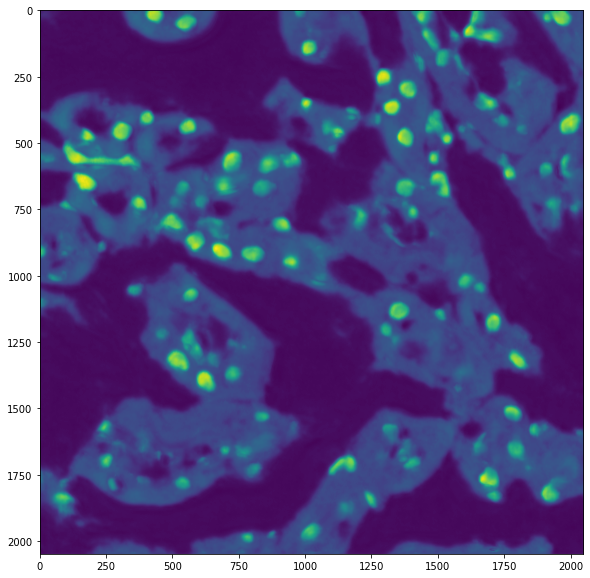

In [44]:
plt.figure(figsize = (10,10))
plt.imshow(np.asarray(PIL.Image.open(tf_pred_paths[0])))

In [ ]:
plt.imshow()

In [9]:
targs = [skimage.util.view_as_blocks(np.asarray(PIL.Image.open(target_path)), (256, 256)) for target_path in target_paths]
tf_preds = [skimage.util.view_as_blocks(np.asarray(PIL.Image.open(tf_pred_path)), (256, 256)) for tf_pred_path in tf_pred_paths]
print(targs[0].shape, tf_preds[0].shape)

(8, 8, 256, 256) (8, 8, 256, 256)


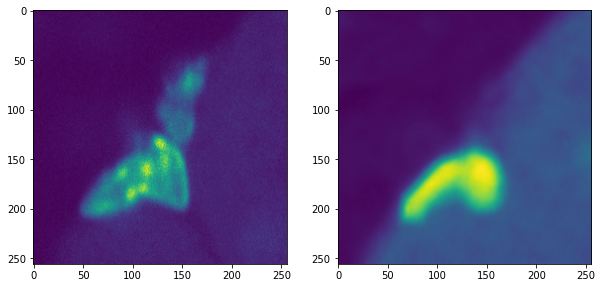

In [24]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(targs[0][6][4])
ax[1].imshow(tf_preds[0][6][4])

In [11]:
met_inst = metrics.MetricsEstimator(metrics_list)

In [12]:
all_tf_metrics = []
for i in range(8):
    row_metrics = []
    for j in range(8):
        met_inst.estimate_xy_metrics(tf_preds[0][i][j], targs[0][i][j], f'tf_scores_{[i,j]}')
        row_metrics.append(met_inst.get_metrics_xy())
    all_tf_metrics.append(row_metrics)

/home/christian.foley/virtual_staining/microDL/micro_dl/inference/evaluation_metrics.py:108: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  data_range=target.max() - target.min(),


In [13]:
all_tf_metrics[0][0]

,ssim,corr,r2,mse,mae,pred_name
0,0.079379,0.651215,-2.089519,60.650009,9359.553787,"tf_scores_[0, 0]_xy0"


In [14]:
model_params = {
    'architecture': '2.5D',
    'in_channels': 1,
    'out_channels': 1,
    'residual': True,
    'task': 'reg', #regression
    'device': torch.device('cuda')
}
model_dir = '/hpc/projects/comp_micro/projects/virtualstaining/torch_microDL_models/Unet25d/training_model_2022_09_06_15_38/saved_model_ep_92_testloss_0.3510.pt'
model_dir = '/hpc/projects/comp_micro/projects/virtualstaining/torch_microDL_models/Unet25d/training_model_2022_09_01_23_22/saved_model_ep_99_testloss_0.4256.pt'

In [15]:
model = inference.load_model_torch(model_dir, model_params)

In [16]:
data_path = '/hpc/projects/CompMicro/projects/virtualstaining/MBL_DL_image_translation/data/care_phase'
img_names = ['img_t000_p011_z010.tif',
            'img_t000_p011_z011.tif',
            'img_t000_p011_z012.tif',
            'img_t000_p011_z013.tif',
            'img_t000_p011_z014.tif']
img_data = [np.asarray(PIL.Image.open(os.path.join(data_path, img_name))) for img_name in img_names]

In [18]:
np_data = skimage.util.view_as_blocks(np.asarray(img_data/np.max(img_data)).astype('float32'), (5,256,256))[0]
np_data.shape

(8, 8, 5, 256, 256)

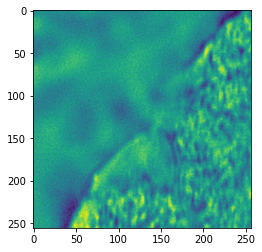

In [25]:
plt.imshow(np_data[6,4,0])

In [34]:
all_pt_metrics = []
all_pt_predictions = []
for i in range(8):
    row_metrics = []
    row_predictions = []
    for j in range(8):
        torch_data = torch.reshape(ds.ToTensor()(np_data[i, j]), (1,1,5,256,256))
        pred = model(torch_data)
        np_pred = pred.detach().cpu().numpy()[0][0][0].astype('uint16')
        row_predictions.append(np_pred)
        
        met_inst.estimate_xy_metrics(np_pred, targs[0][i][j], f'pt_scores_{[i,j]}')
        row_metrics.append(met_inst.get_metrics_xy())
    all_pt_metrics.append(row_metrics)
    all_pt_predictions.append(row_predictions)

/home/christian.foley/.conda/envs/pt_tf_cross/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/christian.foley/virtual_staining/microDL/micro_dl/inference/evaluation_metrics.py:108: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  data_range=target.max() - target.min(),


In [35]:
all_pt_metrics[0][0]

,ssim,corr,r2,mse,mae,pred_name
0,0.000712,0.052696,-268.274866,223.592972,65319.51976,"pt_scores_[0, 0]_xy0"


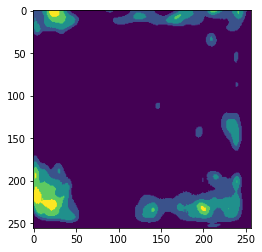

In [41]:
plt.imshow(all_pt_predictions[6][4])

In [26]:
torch_data = torch.reshape(ds.ToTensor()(np_data), (1,1,5,2048,2048))

In [27]:
pred1 = inference.predict_large_image_torch(model, torch_data)

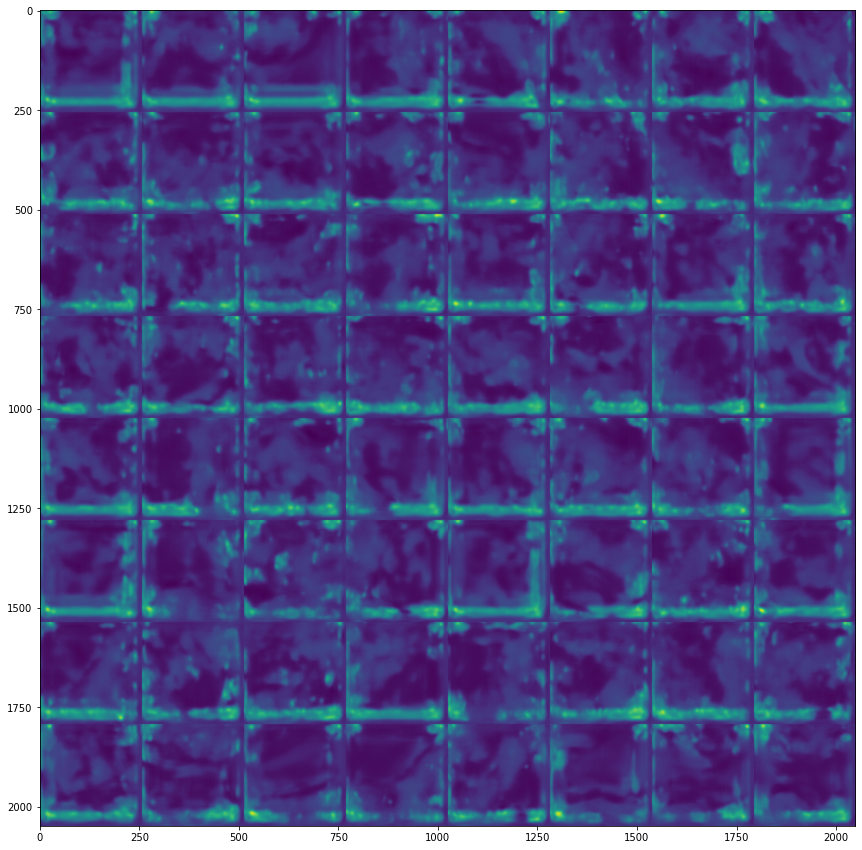

In [28]:
%matplotlib inline
plt.figure(figsize = (15,15))
plt.imshow(pred1[0,0,0])

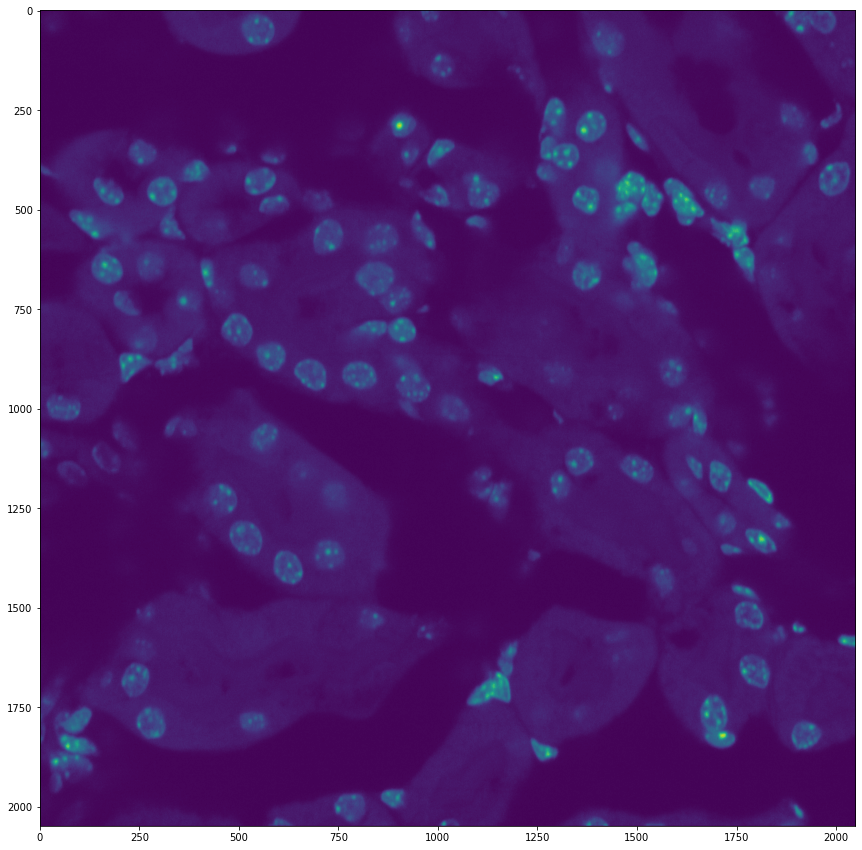

In [21]:
plt.figure(figsize = (15,15))
plt.imshow(targs[0])